In [2]:
#CNN please work time

In [3]:
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np

In [4]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()


# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()


# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.9)    

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()


def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1].item()))

In [5]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import math
import pickle

class ChestXRayDataset(Dataset):
    def __init__(self, train=True):
        with open('train_presentation.pickle', 'rb') as handle:
            train_indices = pickle.load(handle)

        with open('test_presentation.pickle', 'rb') as handle:
            test_indices = pickle.load(handle)

        df = pd.read_csv('data/chest_xray_train.csv')
        df = df.drop(columns=["file_name"])

        X = []
        y = []

        for row in range(len(df)):
            flattened_img = df.iloc[row, :-1].to_numpy()
            matrix_img = np.resize(flattened_img, (64, 64))

            X.append(matrix_img)
            y.append(df.loc[row, "class_id"])

        if train:
            X = [X[i] for i in train_indices]
            y = [y[i] for i in train_indices]
        else:
            X = [X[i] for i in test_indices]
            y = [y[i] for i in test_indices]

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)


In [6]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        # The reason we start with 1 channel is because we have a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Wifth after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total we have out_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        # self.fc1 = nn.Linear(out_2 * 4 * 4, 3)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 3)
    
    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        print(x.shape)
        return x
    
    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

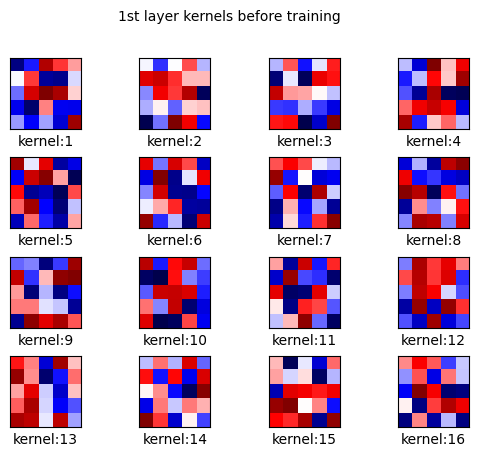

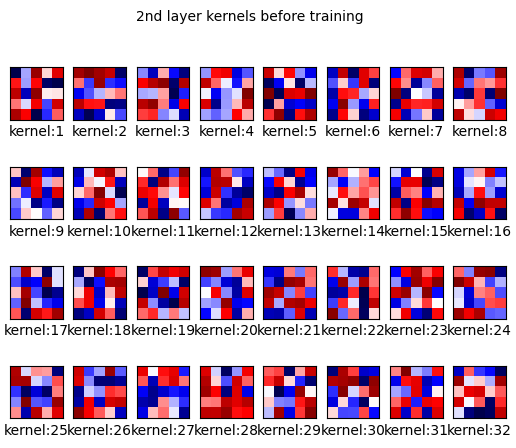

In [7]:
model = CNN(out_1=16, out_2=32)
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [8]:
train_dataset = ChestXRayDataset(True)
validation_dataset = ChestXRayDataset(False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/chest_xray_train.csv'

In [ ]:
print(train_dataset.X.shape,train_dataset.y.shape,validation_dataset.X.shape,validation_dataset.y.shape)

In [ ]:
train_dataset.X = train_dataset.X.float()

In [ ]:
validation_dataset.X.dtype

In [9]:
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# Create a Data Loader for the training data with a batch size of 100 
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Create a Data Loader for the validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=500)

NameError: name 'train_dataset' is not defined

In [75]:
# Train the model

# Number of times we want to train on the taining dataset
n_epochs=3
# List to keep track of cost and accuracy
cost_list=[]
accuracy_list=[]
# Size of the validation dataset
N_test=len(validation_dataset)

# Model Training Function
def train_model(n_epochs):
    # Loops for each epoch
    for epoch in range(n_epochs):
        # Keeps track of cost for each epoch
        COST=0
        # For each batch in train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            x = torch.reshape(x,(100,1,64,64))

            # print(x.shape)
            # break
            z = model(x)
            
            # Measures the loss between prediction and acutal Y value
            # print(z[0][0], type(z))
            loss = criterion(z[0], y[0])
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss 
            COST+=loss.data
        
        # Saves cost of training data of epoch
        cost_list.append(COST)
        # Keeps track of correct predictions
        correct=0
        # Perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            # Makes a prediction
            z = model(x_test)
            # The class with the max value is the one we are predicting
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual value
            correct += (yhat == y_test).sum().item()
        
        # Calcualtes accuracy and saves it
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

RuntimeError: shape '[100, 1, 64, 64]' is invalid for input of size 20480

In [ ]:
import numpy as np

In [ ]:
a = np.array([1,2,3],dtype=np.int16)

In [ ]:
a

In [ ]:
type(a[0])

In [ ]:
a = a.astype(np.float32)

In [ ]:
a

In [ ]:
type(a[0])

In [77]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import math
import pickle

class ChestXRayDataset(Dataset):
    def __init__(self, train=True):
        with open('static_data/train.pickle', 'rb') as handle:
            train_indices = pickle.load(handle)

        with open('static_data/test.pickle', 'rb') as handle:
            test_indices = pickle.load(handle)

        df = pd.read_csv('data/chest_xray_train.csv')
        df = df.drop(columns=["file_name"])

        X = []
        y = []

        for row in range(len(df)):
            flattened_img = df.iloc[row, :-1].to_numpy()
            matrix_img = np.resize(flattened_img, (64, 64))

            X.append(matrix_img)
            y.append(df.loc[row, "class_id"])

        if train:
            X = [X[i] for i in train_indices]
            y = [y[i] for i in train_indices]
        else:
            X = [X[i] for i in test_indices]
            y = [y[i] for i in test_indices]

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)


In [84]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        # The reason we start with 1 channel is because we have a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Width after this layer is 8
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Calculate the size of the input to the fully connected layer dynamically
        # This depends on the input size and the operations performed by the CNN layers
        # You can calculate it based on your architecture
        self.fc_input_size = out_2 * 16  # Adjust this calculation based on your architecture
        
        # Fully connected layer
        self.fc1 = nn.Linear(self.fc_input_size, 3)  # Adjust the number of output features
        
    # Forward method
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

# Assuming you have defined your CNN model class 'CNN' somewhere before
# Define your CNN model
model = CNN()

# Assuming you have defined your criterion (loss function) and optimizer elsewhere
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Assuming you have defined your datasets elsewhere
# Assuming train_dataset and validation_dataset are your training and validation datasets, respectively

# Define the data loaders for the entire datasets
train_loader = torch.utils.data.DataLoader(train_dataset)
validation_loader = torch.utils.data.DataLoader(validation_dataset)

# Define the number of epochs
n_epochs = 3

# List to keep track of cost and accuracy
cost_list = []
accuracy_list = []

# Size of the validation dataset
N_test = len(validation_dataset)

# Model Training Function
def train_model(n_epochs):
    for epoch in range(n_epochs):
        # Keeps track of cost for each epoch
        COST = 0
        # Keeps track of correct predictions
        correct = 0
        total = 0
        
        # Training loop
        model.train()  # Set the model to train mode
        for x, y in train_loader:
            optimizer.zero_grad()
            # Assuming x is the input data and y is the labels
            # Reshape the input tensor if needed
            # x = torch.reshape(x, (x.size(0), 1, 64, 64))
            
            # Forward pass
            outputs = model(x)
            # Calculate loss
            loss = criterion(outputs, y)
            # Backward pass
            loss.backward()
            # Optimize
            optimizer.step()
            # Cumulate loss
            COST += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        
        # Calculate accuracy
        accuracy = correct / total
        accuracy_list.append(accuracy)
        
        # Calculate average loss
        avg_loss = COST / len(train_loader)
        cost_list.append(avg_loss)
        
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {100 * accuracy:.2f}%')

# Start training
train_model(n_epochs)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x256 and 512x3)